<a href="https://colab.research.google.com/github/ArunK-ML/Project---Nutrition-Paradox-A-Global-View-on-Obesity-and-Malnutrition/blob/main/Nutrition_Paradox_Colab_With_MYSQL_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **⚖️ Nutrition Paradox: A Global View on Obesity and Malnutrition**

In [2]:
pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 87.4 MB/s eta 0:00:00


In [5]:
# --------------------------------------------------------------------------------------------------------------------------------------------------------
#                                                             Dataset Overview & Collection
# --------------------------------------------------------------------------------------------------------------------------------------------------------
import requests
import pandas as pd
import numpy as np
import pycountry

# ------------------------------------------
#  Step 1: Fetch Data from WHO API
# ------------------------------------------
# Define API endpoints for obesity and malnutrition (adults and children)
url_Obesity_adults = "https://ghoapi.azureedge.net/api/NCD_BMI_30C"
url_Obesity_children = "https://ghoapi.azureedge.net/api/NCD_BMI_PLUS2C"
url_Malnutrition_adults = "https://ghoapi.azureedge.net/api/NCD_BMI_18C"
url_Malnutrition_children = "https://ghoapi.azureedge.net/api/NCD_BMI_MINUS2C"

# Make GET requests to each API endpoint
response1 = requests.get(url_Obesity_adults)
response2 = requests.get(url_Obesity_children)
response3 = requests.get(url_Malnutrition_adults)
response4 = requests.get(url_Malnutrition_children)

# Parse JSON responses
Obesity_adults = response1.json()
Obesity_children = response2.json()
Malnutrition_adults = response3.json()
Malnutrition_children = response4.json()

# ------------------------------------------
#  Step 2: Convert JSON to DataFrames
# ------------------------------------------
# Extract "value" from each response and convert to DataFrame
Obesity_adults_df = pd.DataFrame(Obesity_adults["value"])
Obesity_children_df = pd.DataFrame(Obesity_children["value"])
Malnutrition_adults_df = pd.DataFrame(Malnutrition_adults["value"])
Malnutrition_children_df = pd.DataFrame(Malnutrition_children["value"])

# Add age group column
Obesity_adults_df["age_group"] = "Adult"
Obesity_children_df["age_group"] = "Child"
Malnutrition_adults_df["age_group"] = "Adult"
Malnutrition_children_df["age_group"] = "Child"

# ------------------------------------------
#  Step 3: Combine Adult and Child Datasets
# ------------------------------------------
df_obesity = pd.concat([Obesity_adults_df, Obesity_children_df], ignore_index=True)
df_malnutrition = pd.concat([Malnutrition_adults_df, Malnutrition_children_df], ignore_index=True)

df_obesity.head()

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#                                                                        🧹 Data Cleaning & Feature Engineering
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------
#  Step 4: Select & Rename Required Columns
# ------------------------------------------
columns_map = {
    "ParentLocationCode": "Region",
    "Dim1": "Gender",
    "TimeDim": "Year",
    "Low": "LowerBound",
    "High": "UpperBound",
    "NumericValue": "Mean_Estimate",
    "SpatialDim": "Country"
}
selected_cols = list(columns_map.keys()) + ["age_group"]

df_obesity = df_obesity[selected_cols].rename(columns=columns_map)
df_malnutrition = df_malnutrition[selected_cols].rename(columns=columns_map)

# ------------------------------------------
#  Step 5: Convert Data Types
# ------------------------------------------
df_obesity["Year"] = df_obesity["Year"].astype(int)
df_malnutrition["Year"] = df_malnutrition["Year"].astype(int)

# ------------------------------------------
#  Step 6: Filter Data for Years 2012–2022
# ------------------------------------------
df_obesity = df_obesity[(df_obesity["Year"] >= 2012) & (df_obesity["Year"] <= 2022)].reset_index(drop=True)
df_malnutrition = df_malnutrition[(df_malnutrition["Year"] >= 2012) & (df_malnutrition["Year"] <= 2022)].reset_index(drop=True)

# ------------------------------------------
#  Step 7: Replace Gender Codes with Labels
# ------------------------------------------
gender_map = {
    "SEX_FMLE": "Female",
    "SEX_BTSX": "Both",
    "SEX_MLE": "Male"
}
df_obesity["Gender"] = df_obesity["Gender"].replace(gender_map)
df_malnutrition["Gender"] = df_malnutrition["Gender"].replace(gender_map)

# ------------------------------------------
#  Step 8: Convert Country Codes to Names
# ------------------------------------------
# Define manual mapping for special WHO and WB codes
special_codes = {
    'GLOBAL': 'Global',
    'WB_LMI': 'Low & Middle Income',
    'WB_HI': 'High Income',
    'WB_LI': 'Low Income',
    'EMR': 'Eastern Mediterranean Region',
    'EUR': 'Europe',
    'AFR': 'Africa',
    'SEAR': 'South-East Asia Region',
    'WPR': 'Western Pacific Region',
    'AMR': 'Americas Region',
    'WB_UMI': 'Upper Middle Income',
    'WLD': 'World',
    'ENG': 'England',
    'SCT': 'Scotland',
    'XK': 'Kosovo',
    'WLS': 'Wales',
    'NIR': 'Northern Ireland',
    'PS': 'Palestine',
    'EU': 'European Union'
}

def code_to_country(code):
    try:
        return pycountry.countries.lookup(code).name
    except:
        return special_codes.get(code, code)

# Apply country name conversion
df_obesity["Country"] = df_obesity["Country"].apply(code_to_country)
df_malnutrition["Country"] = df_malnutrition["Country"].apply(code_to_country)

# ------------------------------------------
#  Step 9: Add CI_Width (Confidence Interval Width)
# ------------------------------------------
df_obesity["CI_Width"] = df_obesity["UpperBound"] - df_obesity["LowerBound"]
df_malnutrition["CI_Width"] = df_malnutrition["UpperBound"] - df_malnutrition["LowerBound"]

# ------------------------------------------
#  Step 10: Add Obesity Level Labels
# ------------------------------------------
obesity_conditions = [
    df_obesity["Mean_Estimate"] >= 30,
    (df_obesity["Mean_Estimate"] >= 25) & (df_obesity["Mean_Estimate"] < 30),
    df_obesity["Mean_Estimate"] < 25
]
obesity_labels = ["High", "Moderate", "Low"]
df_obesity["obesity_level"] = np.select(obesity_conditions, obesity_labels, default="Unknown")

# ------------------------------------------
#  Step 11: Add Malnutrition Level Labels
# ------------------------------------------
malnutrition_conditions = [
    df_malnutrition["Mean_Estimate"] >= 20,
    (df_malnutrition["Mean_Estimate"] >= 10) & (df_malnutrition["Mean_Estimate"] < 20),
    df_malnutrition["Mean_Estimate"] < 10
]
malnutrition_labels = ["High", "Moderate", "Low"]
df_malnutrition["malnutrition_level"] = np.select(malnutrition_conditions, malnutrition_labels, default="Unknown")

# ------------------------------------------
#  Step 12: Preview Final Output
# ------------------------------------------
print("✅ Obesity Data (2012–2022):")
print(df_obesity.head())

print("\n✅ Malnutrition Data (2012–2022):")
print(df_malnutrition.head())


✅ Obesity Data (2012–2022):
  Region  Gender  Year  LowerBound  UpperBound  Mean_Estimate  \
0    EMR    Male  2020   15.793777   19.245727      17.487641   
1    EMR    Male  2020   23.089589   33.815336      28.335530   
2    EUR  Female  2014   24.924766   31.213260      27.948704   
3    EUR  Female  2019   28.160682   35.574925      31.893221   
4    EUR    Both  2018   29.905805   37.470856      33.694205   

                     Country age_group   CI_Width obesity_level  
0  Iran, Islamic Republic of     Adult   3.451950           Low  
1                       Iraq     Adult  10.725747      Moderate  
2                  Greenland     Adult   6.288494      Moderate  
3                    Armenia     Adult   7.414243          High  
4                      Malta     Adult   7.565051          High  

✅ Malnutrition Data (2012–2022):
  Region  Gender  Year  LowerBound  UpperBound  Mean_Estimate  \
0    AFR    Both  2019    4.974405    7.479860       6.147330   
1    EMR    Both  201

# **Step:3 🧮 Exploratory Data Analysis (EDA) with Python**


# **Pandas - Analyzing DataFrames**

In [8]:
print("Obesity Data Shape:", df_obesity.shape)
print("Malnutrition Data Shape:", df_malnutrition.shape)

Obesity Data Shape: (27720, 10)
Malnutrition Data Shape: (27720, 10)


In [9]:
df_obesity.head() , df_malnutrition.head()

(  Region  Gender  Year  LowerBound  UpperBound  Mean_Estimate  \
 0    EMR    Male  2020   15.793777   19.245727      17.487641   
 1    EMR    Male  2020   23.089589   33.815336      28.335530   
 2    EUR  Female  2014   24.924766   31.213260      27.948704   
 3    EUR  Female  2019   28.160682   35.574925      31.893221   
 4    EUR    Both  2018   29.905805   37.470856      33.694205   
 
                      Country age_group   CI_Width obesity_level  
 0  Iran, Islamic Republic of     Adult   3.451950           Low  
 1                       Iraq     Adult  10.725747      Moderate  
 2                  Greenland     Adult   6.288494      Moderate  
 3                    Armenia     Adult   7.414243          High  
 4                      Malta     Adult   7.565051          High  ,
   Region  Gender  Year  LowerBound  UpperBound  Mean_Estimate  \
 0    AFR    Both  2019    4.974405    7.479860       6.147330   
 1    EMR    Both  2013    1.770855    4.654348       3.042609   
 

In [10]:
print("\nObesity Data Info:")
df_obesity.info()

print("\nMalnutrition Data Info:")
df_malnutrition.info()


Obesity Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27720 entries, 0 to 27719
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Region         26268 non-null  object 
 1   Gender         27720 non-null  object 
 2   Year           27720 non-null  int64  
 3   LowerBound     27720 non-null  float64
 4   UpperBound     27720 non-null  float64
 5   Mean_Estimate  27720 non-null  float64
 6   Country        27720 non-null  object 
 7   age_group      27720 non-null  object 
 8   CI_Width       27720 non-null  float64
 9   obesity_level  27720 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 2.1+ MB

Malnutrition Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27720 entries, 0 to 27719
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Region              26268 non-null  object 


In [11]:
# Descriptive statistics for Obesity

print(df_obesity.describe())

# Descriptive statistics for Malnutrition

print(df_malnutrition.describe())

               Year    LowerBound    UpperBound  Mean_Estimate      CI_Width
count  27720.000000  27720.000000  27720.000000   27720.000000  27720.000000
mean    2017.000000      9.393155     17.068488      12.761040      7.675334
std        3.162335      9.893854     12.395013      10.858925      6.616899
min     2012.000000      0.077541      0.547848       0.265672      0.216695
25%     2014.000000      2.354433      7.875503       4.753964      2.926708
50%     2017.000000      6.506534     13.704382       9.944541      5.480536
75%     2020.000000     12.697752     23.986050      17.482417     10.338880
max     2022.000000     74.365371     87.868512      80.609250     40.554062
               Year    LowerBound    UpperBound  Mean_Estimate      CI_Width
count  27720.000000  27720.000000  27720.000000   27720.000000  27720.000000
mean    2017.000000      3.397094      8.147889       5.354451      4.750795
std        3.162335      3.908061      6.443692       4.811220      4.257683

In [12]:
# Describe distribution

print("Obesity - Mean Estimate Stats:\n", df_obesity["Mean_Estimate"].describe())

print("\nMalnutrition - Mean Estimate Stats:\n", df_malnutrition["Mean_Estimate"].describe())

Obesity - Mean Estimate Stats:
 count    27720.000000
mean        12.761040
std         10.858925
min          0.265672
25%          4.753964
50%          9.944541
75%         17.482417
max         80.609250
Name: Mean_Estimate, dtype: float64

Malnutrition - Mean Estimate Stats:
 count    27720.000000
mean         5.354451
std          4.811220
min          0.175309
25%          2.039278
50%          3.597794
75%          7.335245
max         35.894114
Name: Mean_Estimate, dtype: float64


In [14]:
print("Unique values in each column (Obesity):")
for col in df_obesity.columns:
    print(f"{col}: {df_obesity[col].nunique()}")

print("\nUnique values in each column (Malnutrition):")
for col in df_malnutrition.columns:
    print(f"{col}: {df_malnutrition[col].nunique()}")

Unique values in each column (Obesity):
Region: 6
Gender: 3
Year: 11
LowerBound: 27713
UpperBound: 27702
Mean_Estimate: 27712
Country: 210
age_group: 2
CI_Width: 27718
obesity_level: 3

Unique values in each column (Malnutrition):
Region: 6
Gender: 3
Year: 11
LowerBound: 27713
UpperBound: 27704
Mean_Estimate: 27706
Country: 210
age_group: 2
CI_Width: 27718
malnutrition_level: 3


In [15]:
print("Top 10 Countries with most records (Obesity):")
print(df_obesity["Country"].value_counts().head(10))

print("\nTop Regions (Malnutrition):")
print(df_malnutrition["Region"].value_counts())

Top 10 Countries with most records (Obesity):
Country
Iran, Islamic Republic of    132
Iraq                         132
Greenland                    132
Armenia                      132
Malta                        132
Panama                       132
India                        132
Madagascar                   132
Guinea                       132
Philippines                  132
Name: count, dtype: int64

Top Regions (Malnutrition):
Region
EUR     6864
AFR     6204
AMR     4884
WPR     3960
EMR     2904
SEAR    1452
Name: count, dtype: int64


In [16]:
# Obesity by Year and Gender
print("\nObesity - Mean Estimate by Year and Gender:")
print(df_obesity.groupby(["Year", "Gender"])["Mean_Estimate"].mean().unstack())

# Malnutrition by Year and Gender
print("\nMalnutrition - Mean Estimate by Year and Gender:")
print(df_malnutrition.groupby(["Year", "Gender"])["Mean_Estimate"].mean().unstack())


Obesity - Mean Estimate by Year and Gender:
Gender       Both     Female       Male
Year                                   
2012    11.081821  11.087048  11.017039
2013    11.380101  11.375606  11.323205
2014    11.691365  11.679547  11.640118
2015    12.015281  11.997196  11.970216
2016    12.354724  12.327536  12.319461
2017    12.710698  12.670439  12.688854
2018    13.081056  13.022603  13.077230
2019    13.465563  13.383979  13.484270
2020    13.864295  13.757841  13.906869
2021    14.272291  14.140871  14.339606
2022    14.684467  14.526347  14.776783

Malnutrition - Mean Estimate by Year and Gender:
Gender      Both    Female      Male
Year                                
2012    5.574623  4.817657  6.307635
2013    5.516647  4.781361  6.228548
2014    5.464690  4.747856  6.158650
2015    5.418240  4.716901  6.097151
2016    5.376660  4.688553  6.042866
2017    5.339249  4.662791  5.994441
2018    5.305346  4.638870  5.951244
2019    5.276219  4.617948  5.914575
2020    5.25218

# **Pandas - Null value handle**

In [17]:
df_obesity.isnull().sum()

df_malnutrition.isnull().sum()

,0
Region,1452
Gender,0
Year,0
LowerBound,0
UpperBound,0
Mean_Estimate,0
Country,0
age_group,0
CI_Width,0
malnutrition_level,0


In [18]:
df_obesity["Region"].fillna('Special_Case', inplace=True)

df_malnutrition["Region"].fillna('Special_Case', inplace=True)

/tmp/ipython-input-243282317.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_obesity["Region"].fillna('Special_Case', inplace=True)
/tmp/ipython-input-243282317.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [19]:
df_obesity.info() , df_malnutrition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27720 entries, 0 to 27719
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Region         27720 non-null  object 
 1   Gender         27720 non-null  object 
 2   Year           27720 non-null  int64  
 3   LowerBound     27720 non-null  float64
 4   UpperBound     27720 non-null  float64
 5   Mean_Estimate  27720 non-null  float64
 6   Country        27720 non-null  object 
 7   age_group      27720 non-null  object 
 8   CI_Width       27720 non-null  float64
 9   obesity_level  27720 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 2.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27720 entries, 0 to 27719
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Region              27720 non-null  object 
 1   Gender              27720 non-null  obje

(None, None)

# **Pandas - Removing Duplicates**

In [20]:
df_obesity.duplicated().sum()

df_malnutrition.duplicated().sum()

# No duplicate values

np.int64(0)

In [21]:
df_obesity.to_csv('df_obesity_Cleaned_filter.csv', index=False)
df_malnutrition.to_csv('df_malnutrition_Cleaned_filter.csv', index=False)

# **Pandas - Data Correlations**

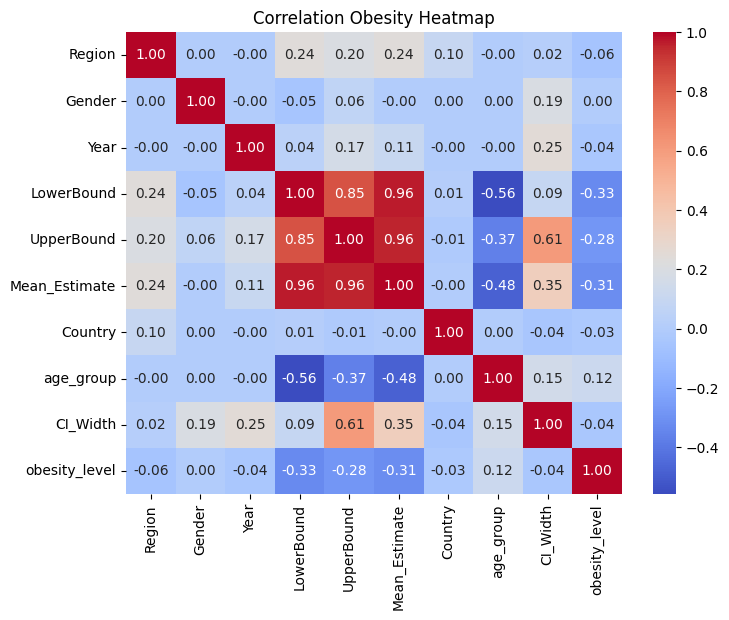

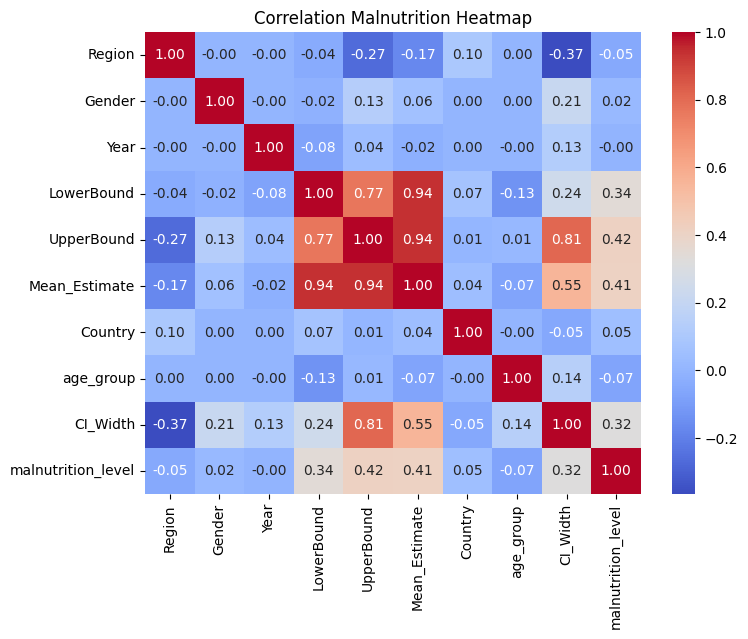

In [27]:


obesity_df_copy = df_obesity.copy()
malnutrition_df_copy = df_malnutrition.copy()

# Encode Categorical Data

from sklearn.preprocessing import LabelEncoder
code = LabelEncoder()

for i in obesity_df_copy.select_dtypes(include="object").columns:
  obesity_df_copy[i] = code.fit_transform(obesity_df_copy[i])

for i in malnutrition_df_copy.select_dtypes(include="object").columns:
  malnutrition_df_copy[i] = code.fit_transform(malnutrition_df_copy[i])

# -----------------------------------------------------------------------------
#                               Correlation Test
# ---------------------------------------------------------------------------

import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------------------
# Calculate correlation for Obesity
# ----------------------------------------
corr_obesity = obesity_df_copy.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_obesity, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Obesity Heatmap")
plt.show()

# ----------------------------------------
# Calculate correlation for Malnutrition
# ----------------------------------------
corr_malnutrition = malnutrition_df_copy.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_malnutrition, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Malnutrition Heatmap")
plt.show()

# **Pandas - visualization Plotting**

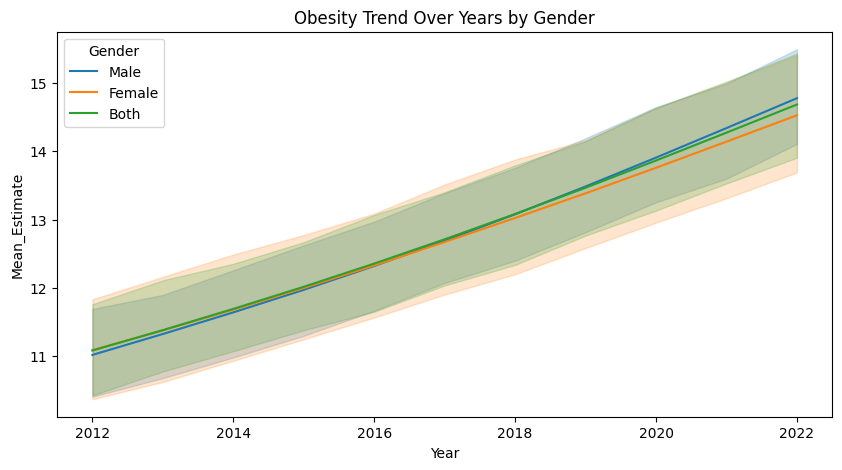

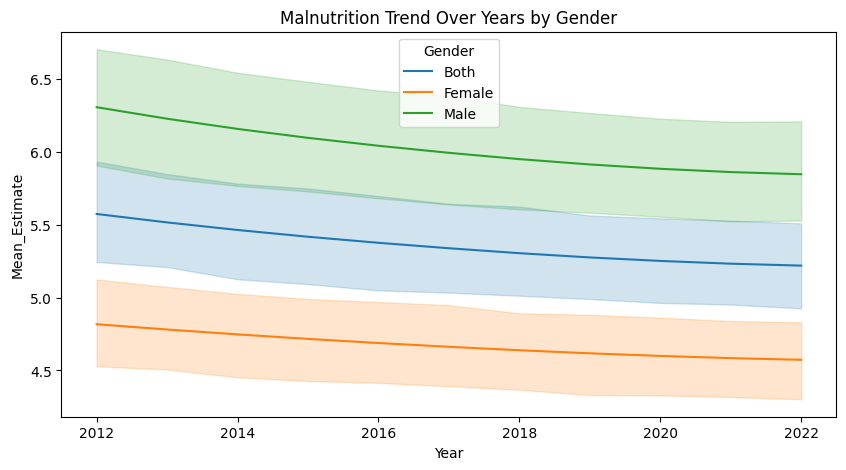

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obesity Trend Over Years
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_obesity, x="Year", y="Mean_Estimate", hue="Gender", estimator="mean")
plt.title("Obesity Trend Over Years by Gender")
plt.show()

# Malnutrition Trend Over Years
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_malnutrition, x="Year", y="Mean_Estimate", hue="Gender", estimator="mean")
plt.title("Malnutrition Trend Over Years by Gender")
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


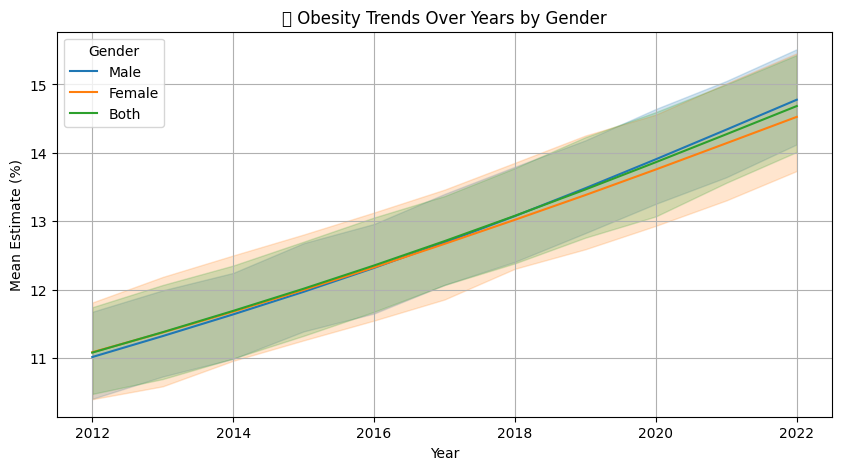

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


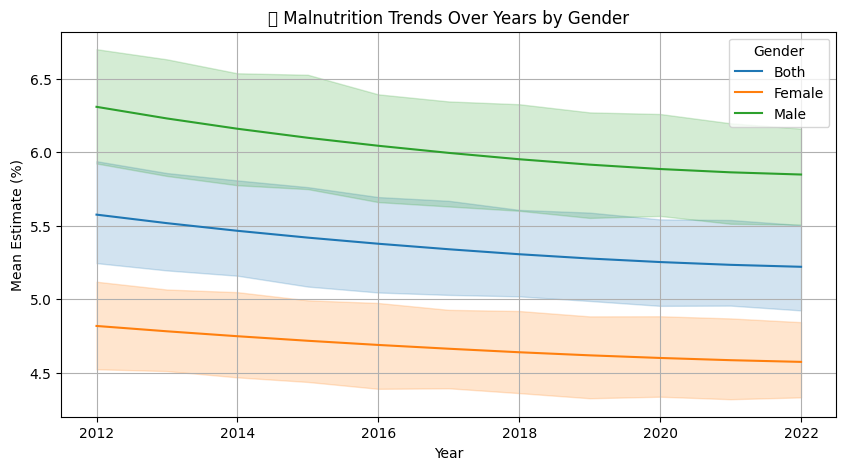

In [29]:
# Line Plots: Trends Over Time

import seaborn as sns
import matplotlib.pyplot as plt

# Obesity
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_obesity, x="Year", y="Mean_Estimate", hue="Gender", estimator="mean")
plt.title("📈 Obesity Trends Over Years by Gender")
plt.ylabel("Mean Estimate (%)")
plt.grid(True)
plt.show()

# Malnutrition
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_malnutrition, x="Year", y="Mean_Estimate", hue="Gender", estimator="mean")
plt.title("📉 Malnutrition Trends Over Years by Gender")
plt.ylabel("Mean Estimate (%)")
plt.grid(True)
plt.show()

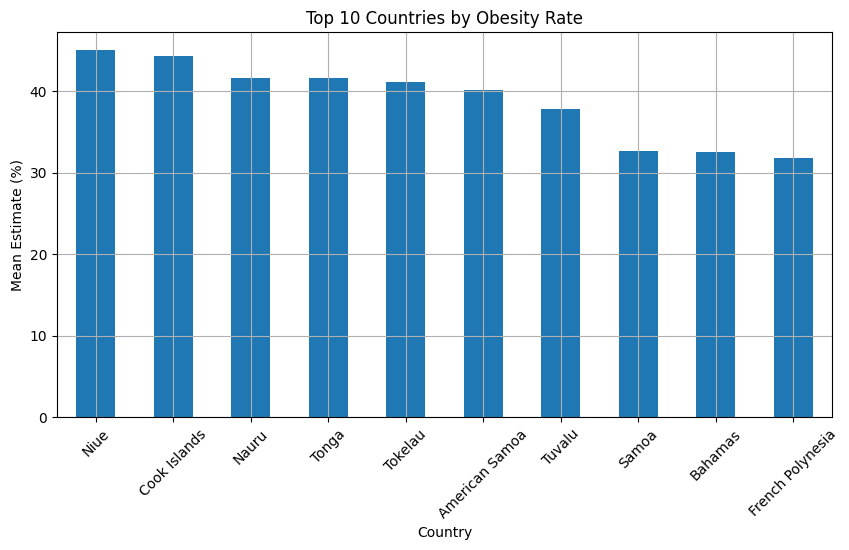

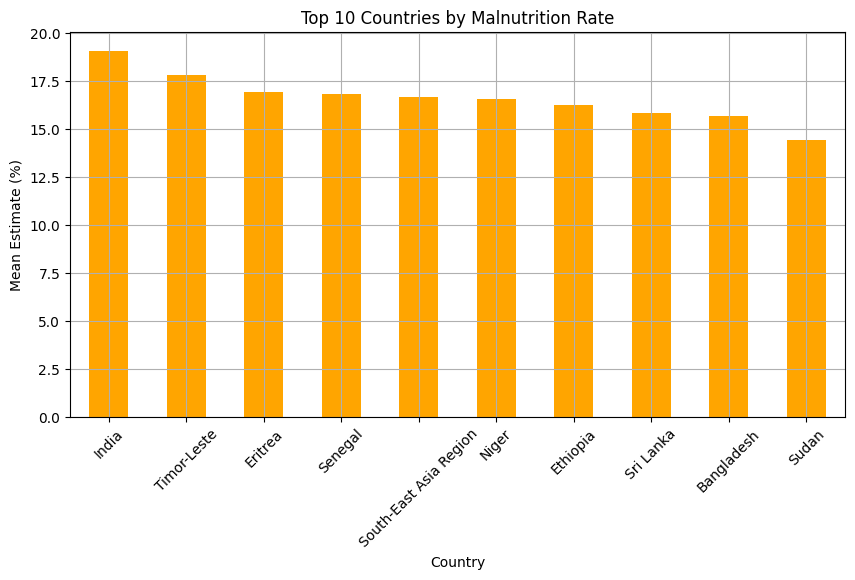

In [30]:
# Bar Chart: Top 10 Countries by Obesity and Malnutrition (Latest Year)

latest_year = df_obesity["Year"].max()

top_obesity = df_obesity[df_obesity["Year"] == latest_year].groupby("Country")["Mean_Estimate"].mean().nlargest(10)
top_malnutrition = df_malnutrition[df_malnutrition["Year"] == latest_year].groupby("Country")["Mean_Estimate"].mean().nlargest(10)

# Plot
top_obesity.plot(kind="bar", figsize=(10, 5), title="Top 10 Countries by Obesity Rate")
plt.ylabel("Mean Estimate (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

top_malnutrition.plot(kind="bar", figsize=(10, 5), color="orange", title="Top 10 Countries by Malnutrition Rate")
plt.ylabel("Mean Estimate (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


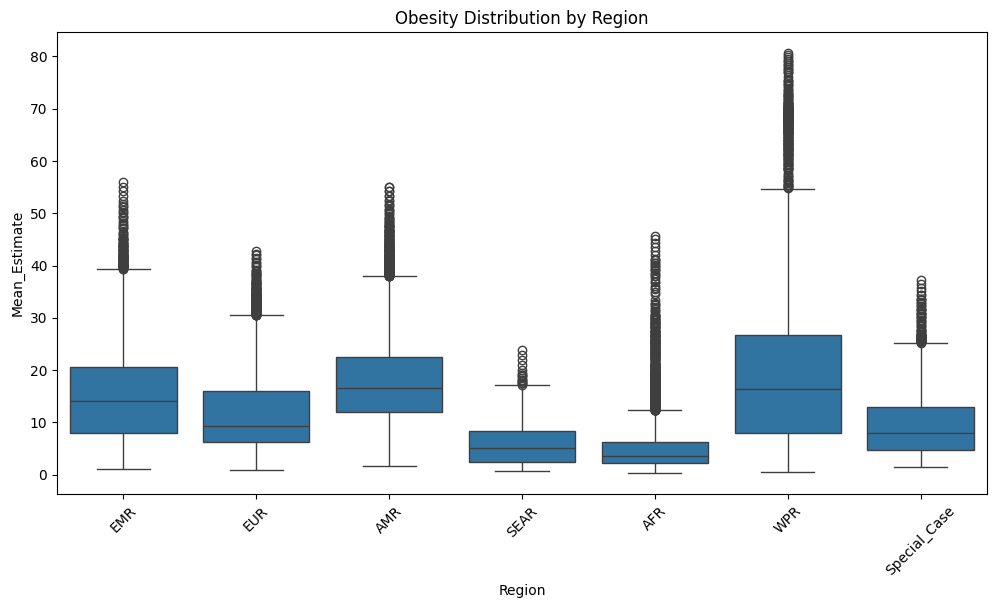

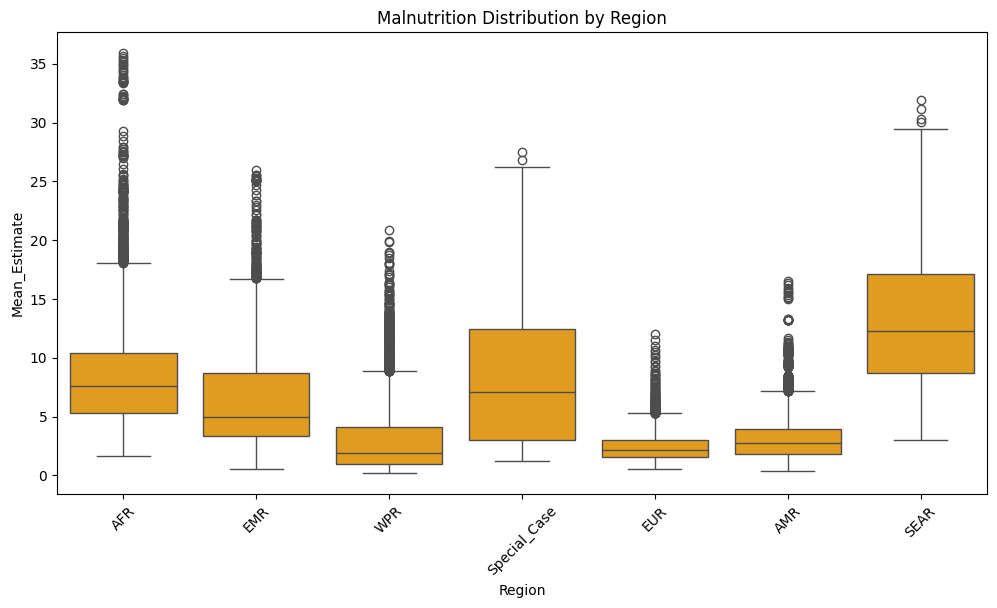

In [31]:
# Box Plots: Variability by Region

# Obesity
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_obesity, x="Region", y="Mean_Estimate")
plt.title("Obesity Distribution by Region")
plt.xticks(rotation=45)
plt.show()

# Malnutrition
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_malnutrition, x="Region", y="Mean_Estimate", color='orange')
plt.title("Malnutrition Distribution by Region")
plt.xticks(rotation=45)
plt.show()


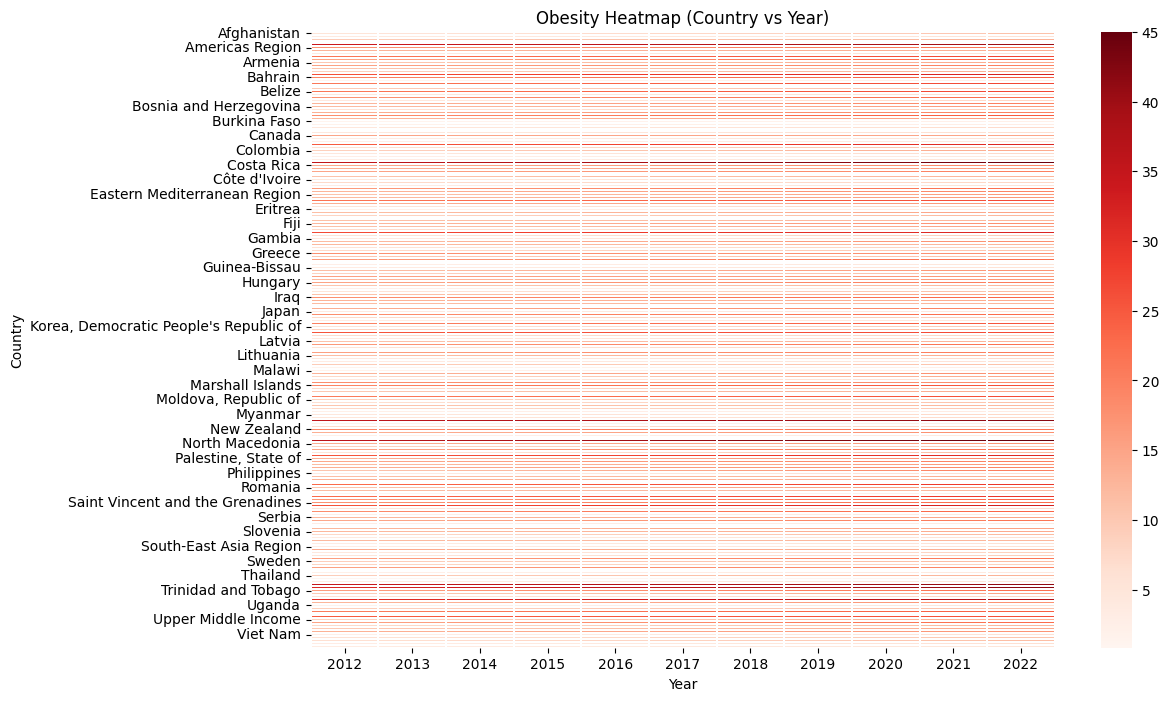

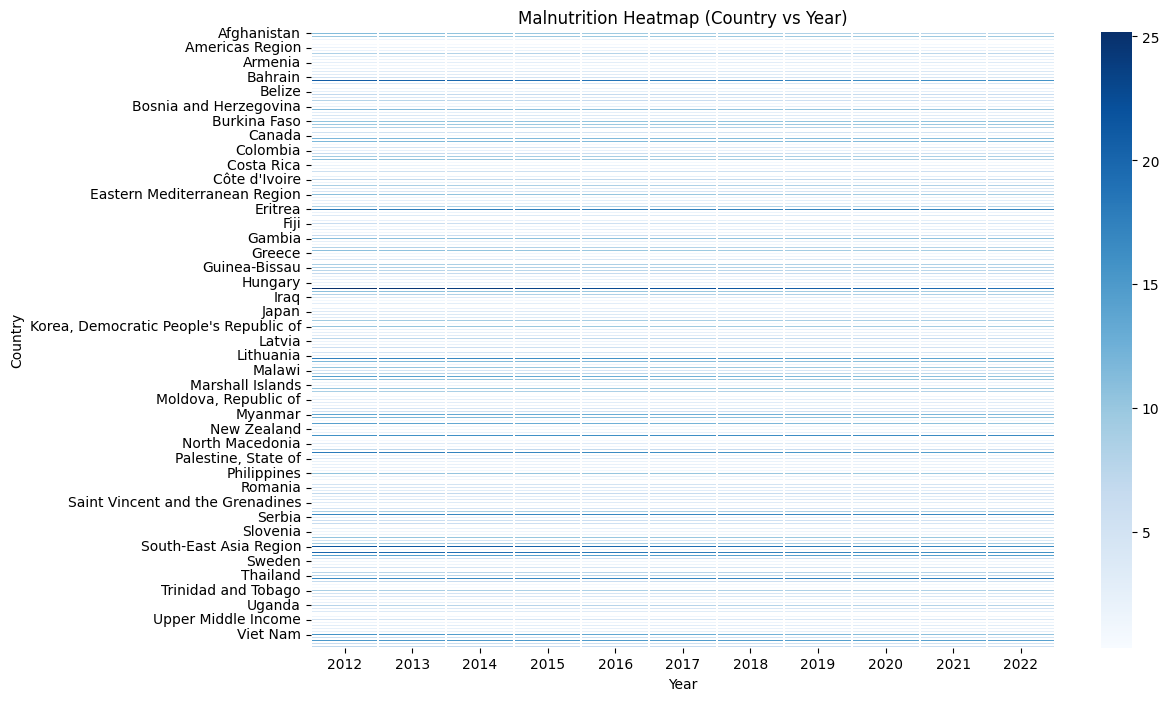

In [32]:
# Heatmap: Country vs Year

# Pivot tables
pivot_obesity = df_obesity.pivot_table(index="Country", columns="Year", values="Mean_Estimate", aggfunc="mean")
pivot_malnutrition = df_malnutrition.pivot_table(index="Country", columns="Year", values="Mean_Estimate", aggfunc="mean")

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_obesity, cmap="Reds", linewidths=0.1)
plt.title("Obesity Heatmap (Country vs Year)")
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_malnutrition, cmap="Blues", linewidths=0.1)
plt.title("Malnutrition Heatmap (Country vs Year)")
plt.show()


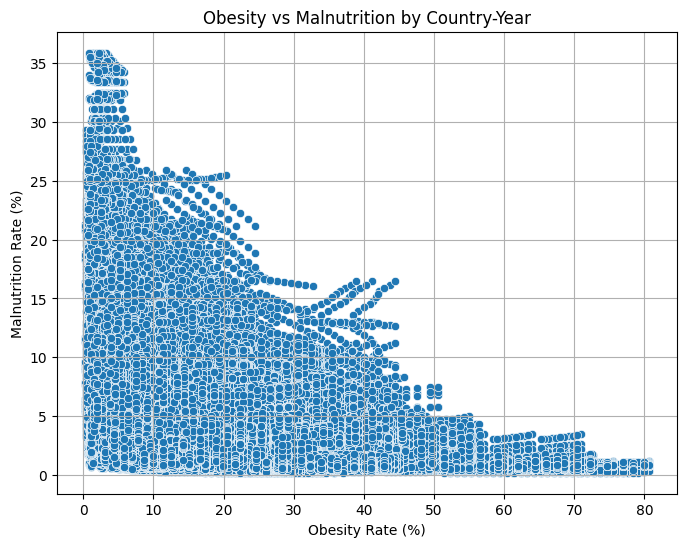

In [33]:
# Compare Obesity vs Malnutrition (Same Country-Year)

# Merge for comparison
df_compare = pd.merge(
    df_obesity[["Country", "Year", "Mean_Estimate"]],
    df_malnutrition[["Country", "Year", "Mean_Estimate"]],
    on=["Country", "Year"],
    suffixes=("_Obesity", "_Malnutrition")
)

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_compare, x="Mean_Estimate_Obesity", y="Mean_Estimate_Malnutrition")
plt.title("Obesity vs Malnutrition by Country-Year")
plt.xlabel("Obesity Rate (%)")
plt.ylabel("Malnutrition Rate (%)")
plt.grid(True)
plt.show()
